# Import Required Libraries
Import necessary libraries including mne, numpy, matplotlib, and custom utilities from the preprocess_tuh.py script.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

# Import custom utilities from preprocess_tuh.py
from preprocess_tuh import select_channels, apply_montage, handle_bad_channels, apply_filters, resample_data, normalize_data, standardize_channels

# Set Up Visualization Functions
Create helper functions for consistent visualization of EEG signals across different preprocessing stages, including functions to plot raw signals, channel maps, and comparison plots.

In [10]:
def read_eeg_segment(file_path, tmin=0, tmax=None, verbose=False):
    """
    Read a specific time segment from an EEG recording file.
    
    Parameters
    ----------
    file_path : str
        Path to the EDF file.
    tmin : float
        Start time of the segment to read in seconds.
    tmax : float or None
        End time of the segment to read in seconds. If None, reads to the end.
    verbose : bool
        Whether to print verbose information.
        
    Returns
    -------
    mne.io.Raw
        The raw EEG data for the specified time segment.
    """
    try:
        # Read the raw EDF file with specified time window
        raw = mne.io.read_raw_edf(file_path, verbose=verbose)
        
        # If tmax is None, use the end of the recording
        if tmax is None:
            tmax = raw.times[-1]
            
        # Crop the data to the specified time range
        raw.crop(tmin=tmin, tmax=tmax)
        
        print(f"Successfully read segment from {tmin}s to {tmax}s")
        return raw
    
    except Exception as e:
        print(f"Error reading file segment: {e}")
        return None

def plot_raw_signals(raw, title="Raw EEG Signals", duration=10, n_channels=None, scalings='auto'):
    """
    Plot raw EEG signals using MNE's built-in visualization.
    
    Args:
        raw: MNE Raw object containing EEG data.
        title: Title of the plot.
        duration: Time window to display at once (in seconds).
        n_channels: Number of channels to display at once.
        scalings: Scaling factor for the traces. 'auto' adjusts automatically.
    
    Returns:
        fig: The figure object from MNE.
    """
    fig = raw.plot(title=title, duration=duration, n_channels=n_channels, scalings=scalings)
    return fig

def plot_channel_map(raw, title="Channel Map", show_names=True, kind='topomap'):
    """
    Plot the channel map to visualize electrode positions using MNE.
    
    Args:
        raw: MNE Raw object containing EEG data.
        title: Title of the plot.
        show_names: Whether to show channel names.
        kind: Type of sensor plot ('topomap' or '3d').
    
    Returns:
        fig: The figure object if successful, None otherwise.
    """
    if raw.get_montage() is not None:
        fig = raw.plot_sensors(show_names=show_names, title=title, kind=kind)
        return fig
    else:
        print("No montage available for the provided raw data.")
        return None

def compare_signals(raw_ref, raw_le, n_channels=5, duration=10,
                  title="Comparison of -REF and -LE Signals"):
    """
    Compare EEG signals between -REF and -LE reference systems.
    
    Args:
        raw_ref: MNE Raw object for -REF reference system.
        raw_le: MNE Raw object for -LE reference system.
        n_channels: Number of channels to display at once.
        duration: Time window to display at once (in seconds).
        title: Title of the plot.
    
    Returns:
        tuple: (fig_ref, fig_le) - The figure objects for each plot.
    """
    print(f"{title} (-REF):")
    fig_ref = raw_ref.plot(n_channels=n_channels, duration=duration, 
                         title=f"{title} (-REF)", scalings='auto')
    
    print(f"{title} (-LE):")
    fig_le = raw_le.plot(n_channels=n_channels, duration=duration, 
                       title=f"{title} (-LE)", scalings='auto')
    
    return fig_ref, fig_le

def compare_signals_psd(raw_ref, raw_le, title="PSD Comparison", 
                      fmin=0, fmax=100, picks=None):
    """
    Compare power spectral density between -REF and -LE reference systems.
    
    Args:
        raw_ref: MNE Raw object for -REF reference system.
        raw_le: MNE Raw object for -LE reference system.
        title: Title of the plot.
        fmin: Minimum frequency to plot.
        fmax: Maximum frequency to plot.
        picks: Channels to plot (default: all shared channels).
    """
    import matplotlib.pyplot as plt
    
    # Find common channels if not specified
    if picks is None:
        picks = list(set(raw_ref.ch_names).intersection(set(raw_le.ch_names)))
    
    # Create figure for spectral comparison
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot PSD for REF
    raw_ref.plot_psd(picks=picks, fmin=fmin, fmax=fmax, ax=axes[0], show=False)
    axes[0].set_title(f"{title} (-REF)")
    
    # Plot PSD for LE
    raw_le.plot_psd(picks=picks, fmin=fmin, fmax=fmax, ax=axes[1], show=False)
    axes[1].set_title(f"{title} (-LE)")
    
    plt.tight_layout()
    plt.show()

# Load Sample EEG Data (-REF and -LE)
Load sample EEG data in both -REF and -LE formats using the read_edf_file function from the preprocessing script.

Successfully read segment from 1500s to 1510s


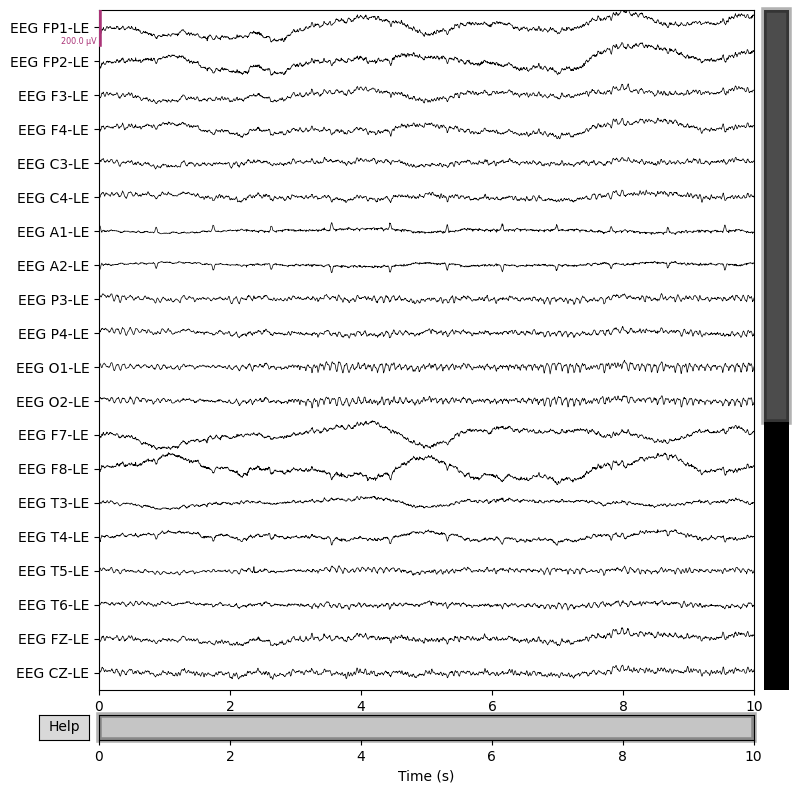

In [37]:
# Load sample EEG data in -REF and -LE formats
AR_EDF_path = '/data/datasets/timeseries/eeg/scalp/tuh/edf/138/aaaaauob/s001_2016_07_05/01_tcp_ar/aaaaauob_s001_t000.edf'
LE_EDF_path = '/data/datasets/timeseries/eeg/scalp/tuh/edf/015/aaaaacgn/s001_2004_06_15/02_tcp_le/aaaaacgn_s001_t000.edf'

t=1500
# Load the raw EEG data with -REF reference system
raw_ref_ar = read_eeg_segment(LE_EDF_path, tmin=t, tmax=t+10, verbose=False)
if raw_ref_ar is None:
    raise ValueError("Failed to load the sample EDF file.")


# Visualize the raw signals for both -REF and -LE
raw_ref_ar.plot(title="Raw EEG Signals (-REF)", scalings='1e-4')
plt.show()

# Select 1020 Channels 

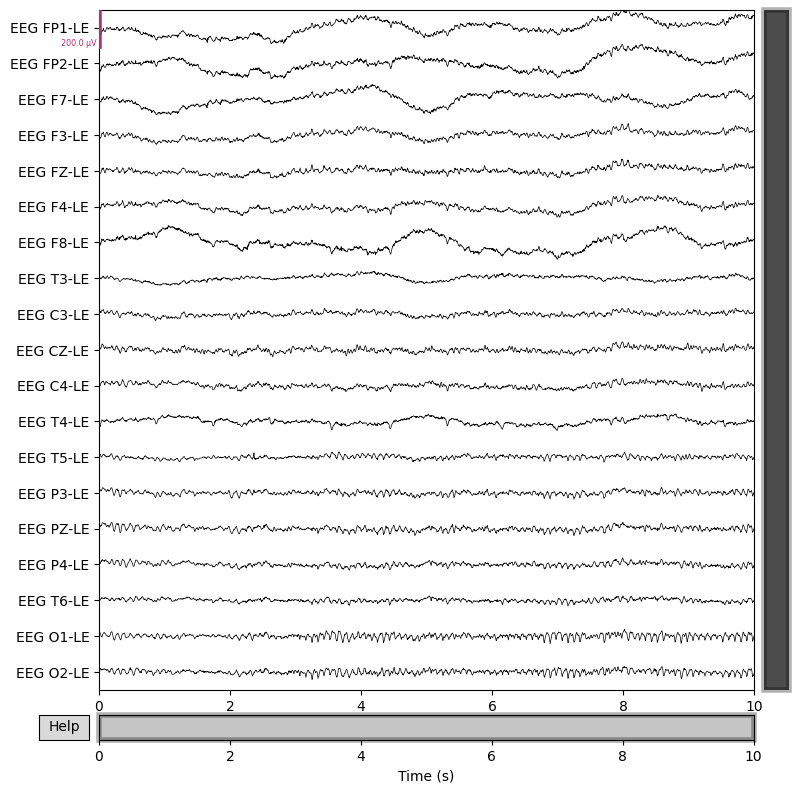

In [39]:

# Select channels for -REF reference system
raw_ref_ar_19 = select_channels(raw_ref_ar, channels_to_use_ref=None, channels_to_use_le=None)
if raw_ref_ar_19 is None:
    raise ValueError("Failed to select channels for -REF reference system.")


# Visualize the raw signals for both -REF and -LE
raw_ref_ar_19.plot(title="Raw EEG Signals (-REF)", scalings='1e-4')
plt.show()

# Montage Application Visualization
Visualize the effect of applying the standard 10-20 montage to the EEG data, showing channel positions and how signals are mapped to standard positions.

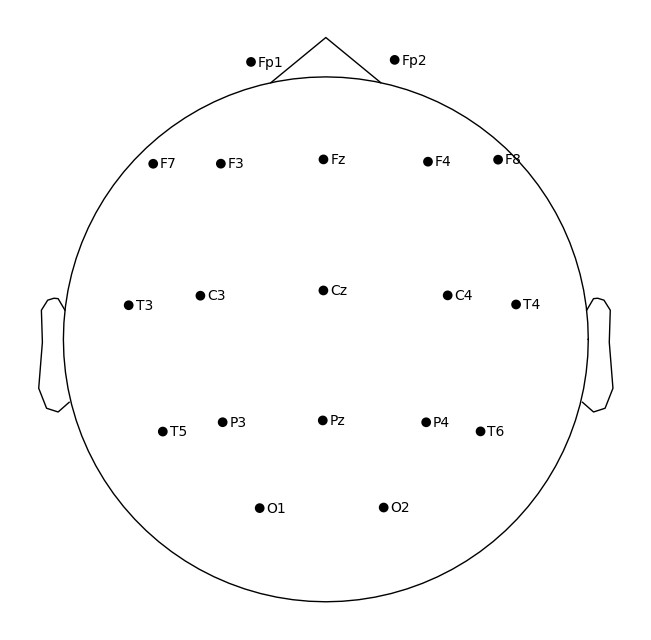

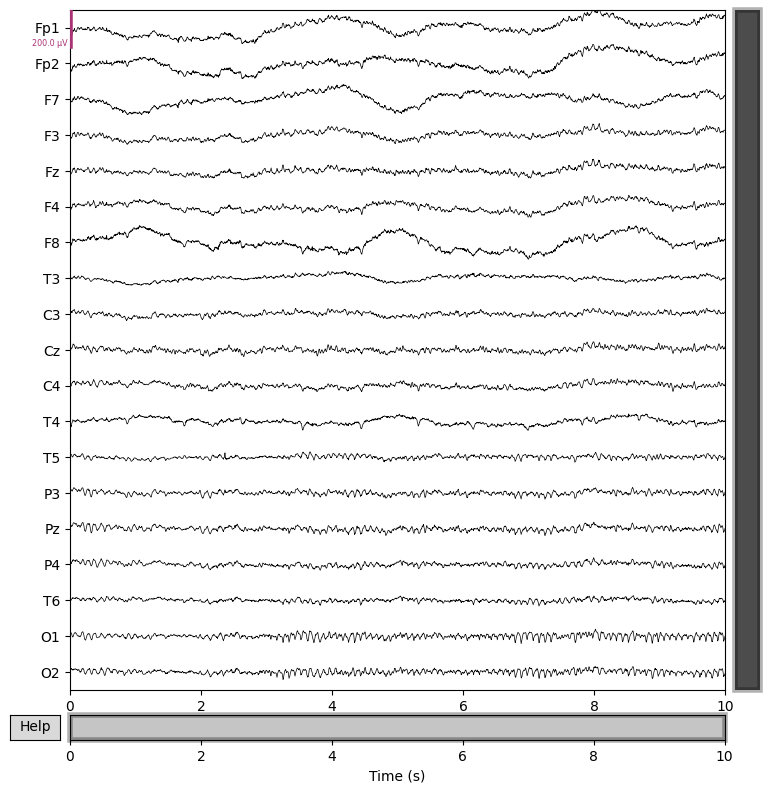

In [41]:
# Montage Application Visualization

# Apply the standard 10-20 montage to the -REF reference system
raw_ref_ar_19_montage = apply_montage(raw_ref_ar_19)

# Plot the channel map for the -REF reference system
plot_channel_map(raw_ref_ar_19_montage, title="Channel Map (-REF)")
plt.show()

raw_ref_ar_19_montage.plot(title="Raw EEG Signals (-REF) with Montage", scalings='1e-4')
plt.show()


# Bad Channel Detection and Interpolation
Detect and visualize bad channels in both reference systems, then show the effect of interpolation on the signal quality.

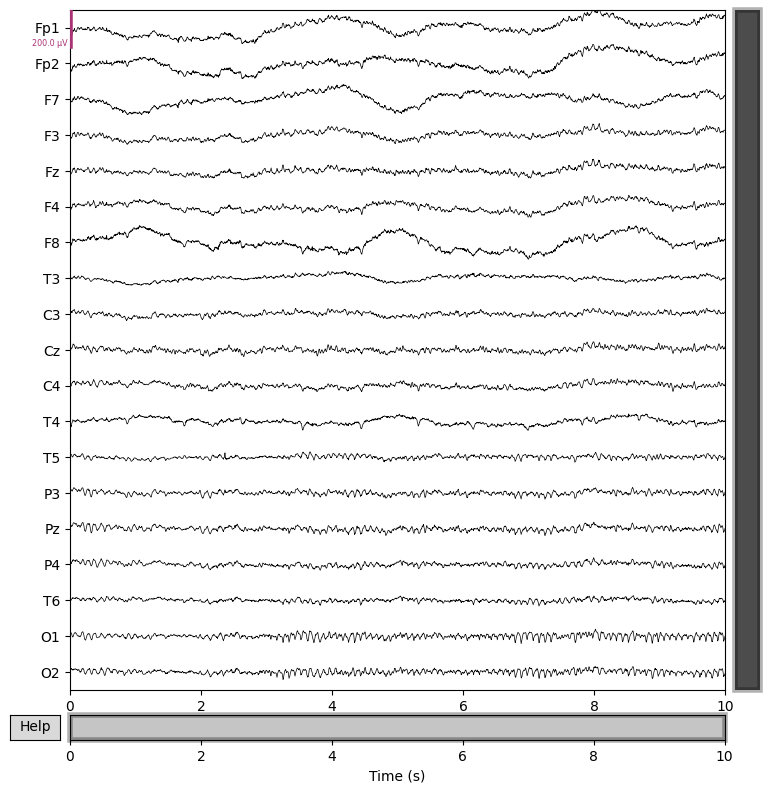

In [42]:
# Bad Channel Detection and Interpolation

# Detect and visualize bad channels for -REF reference system
raw_ref_bad = raw_ref_ar_19_montage.copy()
raw_ref_bad = handle_bad_channels(raw_ref_bad)

raw_ref_bad.plot(title="Raw EEG Signals (-REF) with Bad Channels", scalings='1e-4')
plt.show()

# Filter Application Visualization
Visualize the effects of re-referencing to average, notch filtering, and bandpass filtering on the EEG signals for both reference systems.

In [43]:
# Filter Application Visualization

# Apply filters (re-referencing, notch filter, bandpass filter) to the -REF reference system
raw_ref_filtered = raw_ref_bad.copy()
raw_ref_filtered = apply_filters(raw_ref_filtered)

raw_ref_filtered.plot(title="Raw EEG Signals (-REF) with Filters", scalings='1e-4')
plt.show()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


RuntimeError: By default, MNE does not load data into main memory to conserve resources. Applying a reference requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

# Resampling Visualization
Show how resampling affects the signal quality and time resolution for both reference systems.

In [ ]:
# Resampling Visualization

# Resample the data to a target frequency (e.g., 250 Hz) for -REF reference system
raw_ref_resampled = raw_ref_filtered.copy()
raw_ref_resampled = resample_data(raw_ref_resampled, target_freq=250)

# Resample the data to a target frequency (e.g., 250 Hz) for -LE reference system
raw_le_resampled = raw_le_filtered.copy()
raw_le_resampled = resample_data(raw_le_resampled, target_freq=250)

# Visualize the signals after resampling for -REF
plot_raw_signals(raw_ref_resampled, title="Signals After Resampling (-REF)")

# Visualize the signals after resampling for -LE
plot_raw_signals(raw_le_resampled, title="Signals After Resampling (-LE)")

# Compare the signals after resampling for -REF and -LE
compare_signals(raw_ref_resampled, raw_le_resampled, title="Comparison After Resampling (-REF vs -LE)")

# Normalization Visualization
Visualize the effects of DC offset correction, linear trend removal, and z-score normalization on the EEG signals.

In [ ]:
# Normalization Visualization

# Normalize the data for -REF reference system
data_ref_normalized = normalize_data(raw_ref_resampled.get_data())

# Normalize the data for -LE reference system
data_le_normalized = normalize_data(raw_le_resampled.get_data())

# Visualize the signals after DC offset correction, linear trend removal, and z-score normalization for -REF
plt.figure(figsize=(15, 5))
for i in range(data_ref_normalized.shape[0]):
    plt.plot(raw_ref_resampled.times, data_ref_normalized[i] + i * 100, label=f"Channel {i+1}")
plt.title("Signals After Normalization (-REF)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Visualize the signals after DC offset correction, linear trend removal, and z-score normalization for -LE
plt.figure(figsize=(15, 5))
for i in range(data_le_normalized.shape[0]):
    plt.plot(raw_le_resampled.times, data_le_normalized[i] + i * 100, label=f"Channel {i+1}")
plt.title("Signals After Normalization (-LE)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Compare the normalized signals between -REF and -LE
plt.figure(figsize=(15, 5))
for i in range(data_ref_normalized.shape[0]):
    plt.plot(raw_ref_resampled.times, data_ref_normalized[i] + i * 100, label=f"Channel {i+1} (-REF)", alpha=0.7)
for i in range(data_le_normalized.shape[0]):
    plt.plot(raw_le_resampled.times, data_le_normalized[i] + i * 100, label=f"Channel {i+1} (-LE)", linestyle="--", alpha=0.7)
plt.title("Comparison of Normalized Signals (-REF vs -LE)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Channel Standardization Visualization
Demonstrate how channel standardization ensures a consistent number of channels across different recordings.

In [ ]:
# Channel Standardization Visualization

# Standardize the channel count for -REF reference system
data_ref_standardized, original_channel_count_ref = standardize_channels(data_ref_normalized, target_channels=19)

# Standardize the channel count for -LE reference system
data_le_standardized, original_channel_count_le = standardize_channels(data_le_normalized, target_channels=19)

# Visualize the signals after channel standardization for -REF
plt.figure(figsize=(15, 5))
for i in range(data_ref_standardized.shape[0]):
    plt.plot(raw_ref_resampled.times, data_ref_standardized[i] + i * 100, label=f"Channel {i+1}")
plt.title("Signals After Channel Standardization (-REF)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Visualize the signals after channel standardization for -LE
plt.figure(figsize=(15, 5))
for i in range(data_le_standardized.shape[0]):
    plt.plot(raw_le_resampled.times, data_le_standardized[i] + i * 100, label=f"Channel {i+1}")
plt.title("Signals After Channel Standardization (-LE)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Compare the standardized signals between -REF and -LE
plt.figure(figsize=(15, 5))
for i in range(data_ref_standardized.shape[0]):
    plt.plot(raw_ref_resampled.times, data_ref_standardized[i] + i * 100, label=f"Channel {i+1} (-REF)", alpha=0.7)
for i in range(data_le_standardized.shape[0]):
    plt.plot(raw_le_resampled.times, data_le_standardized[i] + i * 100, label=f"Channel {i+1} (-LE)", linestyle="--", alpha=0.7)
plt.title("Comparison of Standardized Signals (-REF vs -LE)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Compare All Processing Steps
Create a comprehensive visualization comparing signals from each preprocessing step side-by-side for both -REF and -LE reference systems.

In [ ]:
# Compare All Processing Steps

# Create a comprehensive visualization comparing signals from each preprocessing step side-by-side for both -REF and -LE reference systems.

# Define a list of preprocessing steps and their corresponding data
steps = [
    ("Raw Signals", raw_ref, raw_le),
    ("Selected Channels", raw_ref, raw_le),
    ("After Montage Application", raw_ref_montage, raw_le_montage),
    ("After Bad Channel Detection", raw_ref_bad, raw_le_bad),
    ("After Filter Application", raw_ref_filtered, raw_le_filtered),
    ("After Resampling", raw_ref_resampled, raw_le_resampled),
    ("After Normalization", data_ref_normalized, data_le_normalized),
    ("After Channel Standardization", data_ref_standardized, data_le_standardized),
]

# Iterate through each step and visualize the comparison
for step_name, ref_data, le_data in steps:
    if isinstance(ref_data, np.ndarray) and isinstance(le_data, np.ndarray):
        # If the data is a NumPy array (e.g., normalized or standardized data)
        plt.figure(figsize=(15, 5))
        for i in range(ref_data.shape[0]):
            plt.plot(raw_ref_resampled.times, ref_data[i] + i * 100, label=f"Channel {i+1} (-REF)", alpha=0.7)
        for i in range(le_data.shape[0]):
            plt.plot(raw_le_resampled.times, le_data[i] + i * 100, label=f"Channel {i+1} (-LE)", linestyle="--", alpha=0.7)
        plt.title(f"Comparison of {step_name} (-REF vs -LE)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
        plt.tight_layout()
        plt.show()
    else:
        # If the data is an MNE Raw object
        compare_signals(ref_data, le_data, title=f"Comparison of {step_name} (-REF vs -LE)")